In [72]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

# from models import SparseAutoEncoder, MLP, SparseCoding
from utils import generate_data, reconstruction_loss_with_l1
from metrics import mcc, greedy_mcc
from models import SparseAutoEncoder, MLP, SparseCoding

# Autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def calculate_dict_mcc(D_true, D_learned):
    print(D_true.shape, D_learned.shape)
    return greedy_mcc(D_true.cpu().numpy(), D_learned.cpu().numpy())

def train_model(model, X_train, S_train, D_true, num_steps=50_000):
    lr = 1e-4 if isinstance(model, MLP) else 1e-2
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_steps):
        S_, X_ = model(X_train, norm_D=False)
        loss = reconstruction_loss_with_l1(X_train, X_, S_, l1_weight=0.1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            print(f"Loss at step {i}: {loss.item()}")
    
    # Calculate final metrics
    with torch.no_grad():
        S_, _ = model(X_train, norm_D=False)
        latent_mcc = greedy_mcc(S_train.cpu().numpy(), S_.cpu().numpy())
        if isinstance(model, (SparseAutoEncoder, MLP)):
            D_learned = model.decoder.weight.data
        elif isinstance(model, SparseCoding):
            D_learned = model.D.data
        dict_mcc = calculate_dict_mcc(D_true, D_learned)
    
    return latent_mcc, dict_mcc, D_learned

def train_and_get_weights(true_N, model_N, M, K, num_data, seed=20240926):
    # Generate data
    S, X, D = generate_data(true_N, M, K, num_data, seed=seed)
    D = D.T
    X_train = X.to(device)
    S_train = S.to(device)
    D_true = D.to(device)

    # Create a D_random with shape model_N x M
    D_random = torch.randn(M, model_N).to(device)

    # Initialize models
    models = {
        'SparseCoding': SparseCoding(X_train, D_random, learn_D=True, relu_activation=False).to(device),
        'SAE': SparseAutoEncoder(M, model_N, D_true, learn_D=True).to(device),
        'MLP': MLP(M, model_N, 256, D_true, learn_D=True).to(device),
    }

    # Train models and get metrics
    metrics = {}
    decoder_weights = {}
    for name, model in tqdm(models.items(), desc="Training models"):
        latent_mcc, dict_mcc, D_learned = train_model(model, X_train, S_train, D_true)
        metrics[name] = {'latent_mcc': latent_mcc, 'dict_mcc': dict_mcc}
        decoder_weights[name] = D_learned

    return decoder_weights, metrics

In [170]:
# Parameters
true_N, model_N, M, K = 16, 16, 8, 3
num_data = 1024

# Train models and get decoder weights and metrics
decoder_weights, metrics = train_and_get_weights(true_N, model_N, M, K, num_data)

# Print shapes of decoder weights and final metrics
for name, weights in decoder_weights.items():
    print(f"{name}:")
    print(f"  Decoder shape: {weights.shape}")
    print(f"  Final Latent MCC: {metrics[name]['latent_mcc']:.4f}")
    print(f"  Final Dictionary MCC: {metrics[name]['dict_mcc']:.4f}")
    print()

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Loss at step 0: 0.382368266582489
Loss at step 1000: 0.005539735313504934
Loss at step 2000: 0.0020978059619665146
Loss at step 3000: 0.0015566711081191897
Loss at step 4000: 0.0012996725272387266
Loss at step 5000: 0.001090381876565516
Loss at step 6000: 0.0009143475326709449
Loss at step 7000: 0.0007705808966420591
Loss at step 8000: 0.0006508642109110951
Loss at step 9000: 0.0005517923273146152
Loss at step 10000: 0.00047055614413693547
Loss at step 11000: 0.0004034439043607563
Loss at step 12000: 0.00034853757824748755
Loss at step 13000: 0.00030375883216038346
Loss at step 14000: 0.00026692126994021237
Loss at step 15000: 0.00023687009525019675
Loss at step 16000: 0.00021197303431108594
Loss at step 17000: 0.0001916070032166317
Loss at step 18000: 0.00017457078502047807
Loss at step 19000: 0.00016034937289077789
Loss at step 20000: 0.00014850677689537406
Loss at step 21000: 0.00013855198631063104
Loss at step 22000: 0.00013003214553464204
Loss at step 23000: 0.0001226863678311929


Training models:  33%|███▎      | 1/3 [00:13<00:27, 13.71s/it]

torch.Size([8, 16]) torch.Size([8, 16])
Loss at step 0: 1.2638969421386719
Loss at step 1000: 0.009338394738733768
Loss at step 2000: 0.006189793348312378
Loss at step 3000: 0.00488304253667593
Loss at step 4000: 0.004074971657246351
Loss at step 5000: 0.0036685457453131676
Loss at step 6000: 0.0032403122168034315
Loss at step 7000: 0.0027670578565448523
Loss at step 8000: 0.0026221054140478373
Loss at step 9000: 0.0026670778170228004
Loss at step 10000: 0.002251886297017336
Loss at step 11000: 0.002169417915865779
Loss at step 12000: 0.0022411360405385494
Loss at step 13000: 0.002591002034023404
Loss at step 14000: 0.0020437142811715603
Loss at step 15000: 0.0022585270926356316
Loss at step 16000: 0.0022004840429872274
Loss at step 17000: 0.00197781203314662
Loss at step 18000: 0.001978064887225628
Loss at step 19000: 0.0018715596524998546
Loss at step 20000: 0.002244176808744669
Loss at step 21000: 0.0019011551048606634
Loss at step 22000: 0.0018574327696114779
Loss at step 23000: 0.

Training models:  67%|██████▋   | 2/3 [00:24<00:11, 11.99s/it]

torch.Size([8, 16]) torch.Size([8, 16])
Loss at step 0: 0.4744950234889984
Loss at step 1000: 0.025537662208080292
Loss at step 2000: 0.018922781571745872
Loss at step 3000: 0.01634231209754944
Loss at step 4000: 0.014503574930131435
Loss at step 5000: 0.01297127828001976
Loss at step 6000: 0.011681201867759228
Loss at step 7000: 0.010592173784971237
Loss at step 8000: 0.009691799990832806
Loss at step 9000: 0.008940095081925392
Loss at step 10000: 0.008311040699481964
Loss at step 11000: 0.007772097829729319
Loss at step 12000: 0.007301566656678915
Loss at step 13000: 0.006886171642690897
Loss at step 14000: 0.00652157049626112
Loss at step 15000: 0.006201267708092928
Loss at step 16000: 0.005912397056818008
Loss at step 17000: 0.005652949213981628
Loss at step 18000: 0.005419297609478235
Loss at step 19000: 0.005207450594753027
Loss at step 20000: 0.0050131892785429955
Loss at step 21000: 0.004834070336073637
Loss at step 22000: 0.004670002497732639
Loss at step 23000: 0.004517985042

Training models: 100%|██████████| 3/3 [01:03<00:00, 21.11s/it]

torch.Size([8, 16]) torch.Size([8, 16])
SparseCoding:
  Decoder shape: torch.Size([8, 16])
  Final Latent MCC: 0.6134
  Final Dictionary MCC: 0.8019

SAE:
  Decoder shape: torch.Size([8, 16])
  Final Latent MCC: 0.4751
  Final Dictionary MCC: 0.7210

MLP:
  Decoder shape: torch.Size([8, 16])
  Final Latent MCC: 0.4433
  Final Dictionary MCC: 0.7015



In [171]:
d = decoder_weights['SparseCoding']

DT_D = d.T @ d #d @ d.T
DT_D.shape

# Normalize DT_D rows by taking row-wise softmax
DT_D_normalized = torch.nn.functional.softmax(DT_D, dim=1)

0.0 1.0
perfect


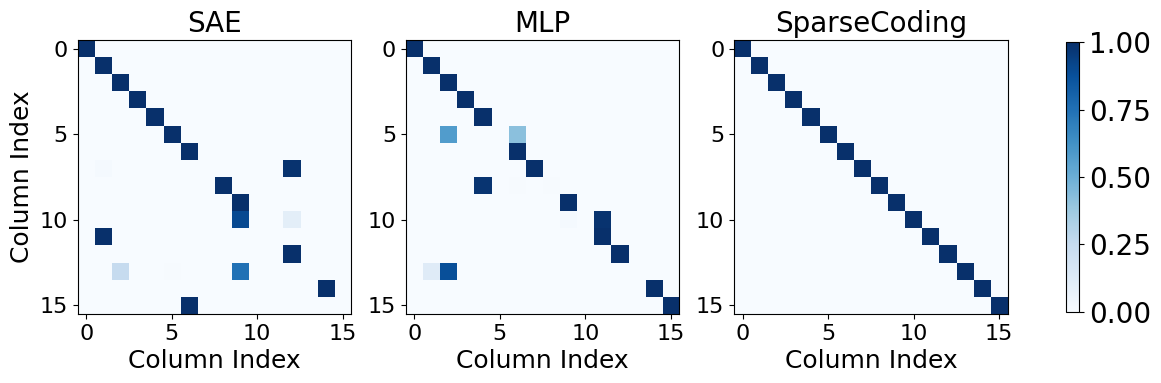

In [172]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_heatmaps(decoder_weights, base_fontsize=20):
    # Set up the figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Calculate the global color scale range
    all_values = []
    for model_name in ['SAE', 'MLP', 'SparseCoding']:
        d = decoder_weights[model_name]
        DT_D = d.T @ d
        # Normalise row-wise
        DT_D_normalized = torch.nn.functional.softmax(DT_D, dim=1)
        all_values.extend(DT_D_normalized.flatten().tolist())

    vmin, vmax = min(all_values), max(all_values)
    print(vmin, vmax)

    # Plot for each model
    for ax, model_name in zip(axes, ['SAE', 'MLP', 'SparseCoding']):
        d = decoder_weights[model_name]
        DT_D = d.T @ d
        DT_D_normalized = torch.nn.functional.softmax(DT_D, dim=1).cpu().numpy()

        im = ax.imshow(DT_D_normalized, cmap='Blues', vmin=vmin, vmax=vmax)
        ax.set_title(model_name, fontsize=base_fontsize)
        ax.set_xlabel("Column Index", fontsize=base_fontsize * 0.9)
        if model_name == 'SAE':
            ax.set_ylabel("Column Index", fontsize=base_fontsize * 0.9)
        ax.tick_params(axis='both', which='major', labelsize=base_fontsize * 0.8)

    # Add colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
    cbar.ax.tick_params(labelsize=base_fontsize * 1.0)

    # Adjust layout and display
    #plt.tight_layout()
    if true_N < model_N:
        suffix = "over"
    elif true_N > model_N:
        suffix = "under"
    else:
        suffix = "perfect"
    print(suffix)
    plt.savefig(f"results/figures/DT_D_{suffix}.pdf", bbox_inches='tight')
    plt.show()

plot_heatmaps(decoder_weights)

In [160]:
# Show the norm of the columns of D
D_norms = np.linalg.norm(d, axis=0)
# Bar chart of the norms of the columns of D
fig = px.bar(x=np.arange(len(D_norms)), y=D_norms, labels={'x':'Column Index', 'y':'Norm'}, title='Norm of Columns of D')
fig.update_layout(width=800, height=500)
fig.show()

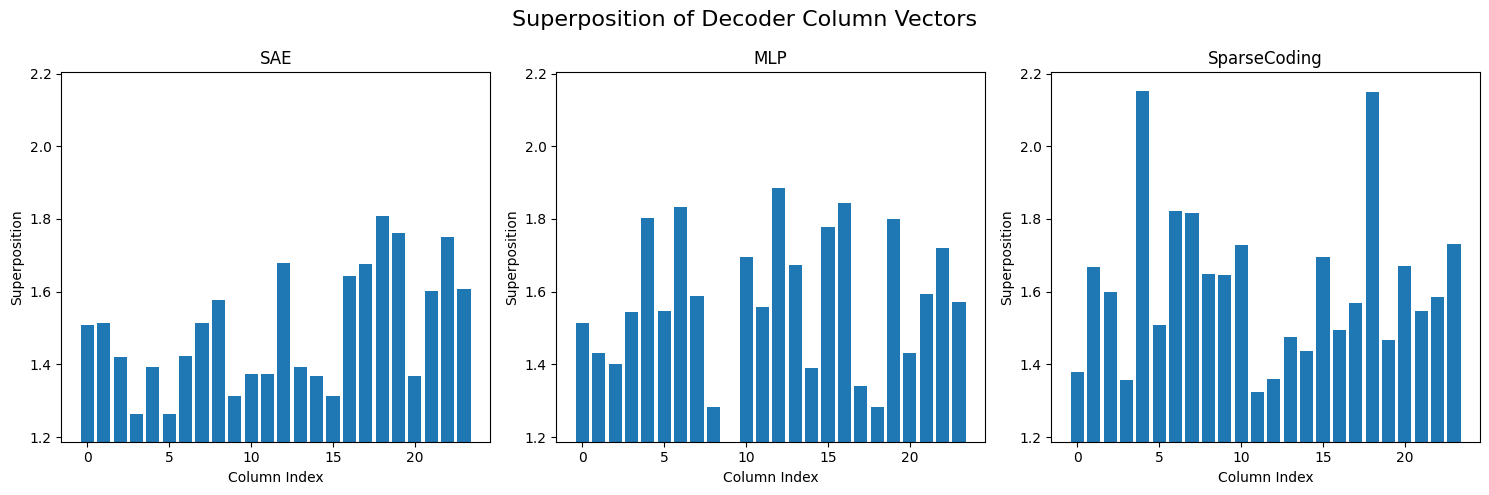

In [161]:
import einops
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate superposition for a given decoder
def calculate_superposition(d):
    model_N = d.shape[1]
    superpositions = np.zeros(model_N)
    for i in range(model_N):
        vec_i = d[:, i]
        vec_i = vec_i / np.linalg.norm(vec_i)
        for j in range(model_N):
            if i != j:
                vec_j = d[:, j]
                vec_j = vec_j / np.linalg.norm(vec_j)
                superposition_measure = (vec_i @ vec_j)**2
                superpositions[i] += superposition_measure
    return np.sqrt(superpositions)

# Create 1x3 subfigures
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Superposition of Decoder Column Vectors', fontsize=16)

# Calculate the global y-axis range
all_superpositions = []
for model_name in ['SAE', 'MLP', 'SparseCoding']:
    d = decoder_weights[model_name]
    superpositions = calculate_superposition(d)
    all_superpositions.extend(superpositions)

y_min, y_max = min(all_superpositions), max(all_superpositions)

for idx, model_name in enumerate(['SAE', 'MLP', 'SparseCoding']):
    d = decoder_weights[model_name]
    superpositions = calculate_superposition(d)
    
    axes[idx].bar(np.arange(len(superpositions)), superpositions)
    axes[idx].set_title(f'{model_name}')
    axes[idx].set_xlabel('Column Index')
    axes[idx].set_ylabel('Superposition')
    axes[idx].set_ylim(y_min, y_max+0.05)  # Set the same y-axis range for all subplots

plt.tight_layout()
plt.show()

## Activation shrinkage experiment

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def calculate_dict_mcc(D_true, D_learned):
    print(D_true.shape, D_learned.shape)
    return greedy_mcc(D_true.cpu().numpy(), D_learned.cpu().numpy())

def train_model(model, X_train, S_train, D_true, num_steps=100_000):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for i in range(num_steps):
        S_, X_ = model(X_train, norm_D=True)
        loss = reconstruction_loss_with_l1(X_train, X_, S_, l1_weight=0.01)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i+1 == num_steps:
            print(f"Loss at step {i+1}: {loss.item()}")
    
    # Calculate final metrics
    with torch.no_grad():
        S_, X_ = model(X_train, norm_D=True)
        latent_mcc = greedy_mcc(S_train.cpu().numpy(), S_.cpu().numpy())
        if isinstance(model, (SparseAutoEncoder, MLP)):
            D_learned = model.decoder.weight.data
        elif isinstance(model, SparseCoding):
            D_learned = model.D.data
        dict_mcc = calculate_dict_mcc(D_true, D_learned)
        print(f"Latent MCC: {latent_mcc}")
        print(f"Dict MCC: {dict_mcc}")
        recon_loss = reconstruction_loss_with_l1(X_train, X_, S_, l1_weight=0.01)
        print(f"Recon Loss: {recon_loss}")
    
    return latent_mcc, dict_mcc, model

def train_and_get_weights(true_N, model_N, M, K, num_data, seed=3): #20240926):
    # Generate data
    S, X, D = generate_data(true_N, M, K, num_data, seed=seed)
    D = D.T
    X_train = X.to(device)
    S_train = S.to(device)
    D_true = D.to(device)

    # Create a D_random with shape model_N x M
    D_random = torch.randn(M, model_N).to(device)

    # Initialize models
    models = {
        'SparseCoding': SparseCoding(X_train, D_random, learn_D=True).to(device),
        'SAE': SparseAutoEncoder(M, model_N, D_true, learn_D=True).to(device),
        'MLP': MLP(M, model_N, 32, D_true, learn_D=True).to(device),
    }

    # Train models and get metrics
    return_dict = {}
    for name, model in tqdm(models.items(), desc="Training models"):
        latent_mcc, dict_mcc, model = train_model(model, X_train, S_train, D_true)
        return_dict[name] = {'latent_mcc': latent_mcc, 'dict_mcc': dict_mcc, 'model': model}

    return return_dict, S, X, D

In [54]:
# Parameters
true_N, model_N, M, K = 16, 12, 6, 3
num_data = 1024

# Train models and get decoder weights and metrics
return_dict, S, X, D = train_and_get_weights(true_N, model_N, M, K, num_data)

SAE decoder shape = torch.Size([6, 12])
SAE decoder shape = torch.Size([6, 12])
MLP decoder shape = torch.Size([6, 12])
MLP decoder shape = torch.Size([6, 12])


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Loss at step 100000: 0.0026482767425477505
torch.Size([6, 16]) torch.Size([6, 12])
Latent MCC: 0.6163550895247597
Dict MCC: 0.8290127604841473


Training models:  33%|███▎      | 1/3 [00:33<01:06, 33.03s/it]

Recon Loss: 0.002648277673870325
Loss at step 100000: 0.0026837976183742285
torch.Size([6, 16]) torch.Size([6, 12])


Training models:  67%|██████▋   | 2/3 [00:54<00:26, 26.03s/it]

Latent MCC: 0.5666355003354323
Dict MCC: 0.8325525889100996
Recon Loss: 0.0026837741024792194
Loss at step 100000: 0.0029413870070129633
torch.Size([6, 16]) torch.Size([6, 12])
Latent MCC: 0.5278733003662573
Dict MCC: 0.8603106870127704


Training models: 100%|██████████| 3/3 [01:28<00:00, 29.46s/it]

Recon Loss: 0.002941241953521967


In [55]:
# Get the activations on some test data
S_test, X_test, D_test = generate_data(true_N, M, K, num_data, seed=20240926+3)

activations_dict = {}
decoder_dict = {}

# Get the activations of the test data
for name, model_dict in return_dict.items():
    model = model_dict['model']
    if isinstance(model, SparseCoding):
        S_final = model.optimize_codes(X_test, num_iterations=15_000, lr=1e-3, l1_weight=0.01)
        decoder_dict[name] = model.D.data
        X_final = S_final @ model.D.T
    elif isinstance(model, SparseAutoEncoder) or isinstance(model, MLP):
        S_final, X_final = model(X_test, norm_D=False)
        decoder_dict[name] = model.decoder.weight.data

    # Set everything below epsilon threshold to zero
    S_final = S_final.clone()
    #S_final[S_final < 5e-5] = 0

    print(f"{name} activations shape: {S_final.shape}")
    recon_loss = reconstruction_loss_with_l1(X_test, X_final, S_final, l1_weight=0.01)
    print(f"{name} reconstruction loss: {recon_loss}")
    print(f"{name} activations L0 norm: {torch.norm(S_final, p=0)}")
    print(f"{name} activations L1 norm: {torch.norm(S_final, p=1)}")
    print(f"{name} activations mean: {S_final.mean()}")
    print(f"{name} activations std: {S_final.std()}")
    print(f"{name} activations min: {S_final.min()}")
    print(f"{name} activations max: {S_final.max()}\n\n")

    activations_dict[name] = S_final

SparseCoding activations shape: torch.Size([1024, 12])
SparseCoding reconstruction loss: 0.01065655518323183
SparseCoding activations L0 norm: 12288.0
SparseCoding activations L1 norm: 3577.93408203125
SparseCoding activations mean: 0.2911786139011383
SparseCoding activations std: 0.4912368357181549
SparseCoding activations min: 1.9319190869282465e-06
SparseCoding activations max: 4.732790470123291


SAE activations shape: torch.Size([1024, 12])
SAE reconstruction loss: 0.014566922560334206
SAE activations L0 norm: 6632.0
SAE activations L1 norm: 3434.11767578125
SAE activations mean: 0.2794692814350128
SAE activations std: 0.43851205706596375
SAE activations min: 0.0
SAE activations max: 4.207516670227051


MLP activations shape: torch.Size([1024, 12])
MLP reconstruction loss: 0.01306367851793766
MLP activations L0 norm: 6856.0
MLP activations L1 norm: 4542.9697265625
MLP activations mean: 0.36970794200897217
MLP activations std: 0.5542178750038147
MLP activations min: 0.0
MLP activat

In [56]:
import plotly.express as px

print(activations_dict['SparseCoding'].shape)

# Histogram of the activations
fig = px.histogram(activations_dict['SparseCoding'].flatten().cpu().numpy(), nbins=100, title='Histogram of SparseCoding Activations')
fig.update_layout(width=800, height=500)
fig.show()

torch.Size([1024, 12])


In [67]:
model_name = 'SAE'

# Get the activations of the test data
S_ = activations_dict[model_name]
D_ = decoder_dict[model_name]

# Get the mask of where the activations are non-zero
mask = S_ > 0
# Convert mask to an integer tensor
mask = mask.to(torch.int)

X_hat = S_ @ D_.T
loss = reconstruction_loss_with_l1(X_test, X_hat, S_, l1_weight=0.01)
print(f"Loss: {loss}")

Loss: 0.014566922560334206


In [68]:
# Define an optimisation loop to optimise the non-zero codes to minimise the loss
S_opt = S_.clone().detach().requires_grad_(True)
optimizer = torch.optim.Adam([S_opt], lr=1e-3)
num_iterations = 1000

for i in range(num_iterations):
    optimizer.zero_grad()
    # Apply ReLU to the activations
    #S_opt = F.relu(S_opt)
    X_hat = S_opt @ D_.T
    loss = reconstruction_loss_with_l1(X_test, X_hat, S_opt, l1_weight=0.01)
    loss.backward()
    
    # Apply the mask to the gradients to only update non-zero codes
    S_opt.grad *= mask
    
    optimizer.step()

    # Project back to non-negative values
    with torch.no_grad():
        S_opt.clamp_(min=0)

    if i % 100 == 0:
        print(f"Loss at iteration {i}: {loss.item()}")
    
S_opt = S_opt.detach()
print(f"Final loss: {loss.item()}")


Loss at iteration 0: 0.014566922560334206
Loss at iteration 100: 0.011128508485853672
Loss at iteration 200: 0.009042900986969471
Loss at iteration 300: 0.0075432313606143
Loss at iteration 400: 0.006426782812923193
Loss at iteration 500: 0.005586803890764713
Loss at iteration 600: 0.004952864721417427
Loss at iteration 700: 0.004474766552448273
Loss at iteration 800: 0.004114959854632616
Loss at iteration 900: 0.0038450253196060658
Final loss: 0.003645123913884163


In [69]:
S_opt

tensor([[0.0536, 0.4189, 0.0000,  ..., 0.0000, 1.2649, 0.0000],
        [0.0000, 0.0965, 0.0000,  ..., 0.2342, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.5788, 0.0000, 0.4493],
        ...,
        [0.0000, 0.5615, 0.0000,  ..., 0.5759, 0.0000, 0.0000],
        [0.0000, 0.3278, 0.0000,  ..., 2.6852, 0.0000, 0.0000],
        [0.7338, 0.0000, 0.0000,  ..., 1.1417, 0.0000, 0.0000]])

In [70]:
S_

tensor([[0.1244, 0.4352, 0.0000,  ..., 0.0000, 1.2577, 0.0000],
        [0.0920, 0.1189, 0.0000,  ..., 0.2636, 0.0000, 0.0000],
        [0.0715, 0.0000, 0.0000,  ..., 0.6038, 0.0000, 0.4327],
        ...,
        [0.0124, 0.5676, 0.0000,  ..., 0.5844, 0.0000, 0.0000],
        [0.0000, 0.2975, 0.0000,  ..., 2.6579, 0.0000, 0.0000],
        [0.2083, 0.0000, 0.0000,  ..., 0.9811, 0.0000, 0.0871]],
       grad_fn=<CloneBackward0>)

In [71]:
import plotly.graph_objects as go

# Use the mask to get corresponding values in S_ and S_opt
S_masked = S_.flatten()[mask.flatten()]
S_opt_masked = S_opt.flatten()[mask.flatten()]

print(S_masked.shape)
print(S_opt_masked.shape)

# Calculate the difference between corresponding activations where S_ is non-zero
activation_diff = []
for i in range(S_.numel()):
    if S_.flatten()[i] != 0:
        diff = S_opt.flatten()[i] - S_.flatten()[i]
        activation_diff.append(diff)

activation_diff = torch.tensor(activation_diff)
print(activation_diff)

print(f"Activation difference mean: {activation_diff.mean()}")
print(f"Activation difference shape: {activation_diff.shape}")

# Plotly histogram of the difference in activations
fig = go.Figure()
fig.add_trace(go.Histogram(x=activation_diff.tolist(), name='Activation Difference', opacity=0.7))

# Add a vertical line for the mean
mean_value = activation_diff.mean()
fig.add_vline(x=mean_value, line_dash="dash", line_color="red", annotation_text=f"Mean: {mean_value:.4f}", annotation_position="top right")

fig.update_layout(
    title='Histogram of Activation Differences (Optimized - Original)',
    xaxis_title='Activation Difference',
    yaxis_title='Count',
    width=800,
    height=500
)

fig.show()

torch.Size([12288])
torch.Size([12288])
tensor([-0.0708, -0.0163, -0.0532,  ...,  0.2595,  0.1606, -0.0871])
Activation difference mean: 0.015574456192553043
Activation difference shape: torch.Size([6632])


In [75]:
activation_diff

tensor([-3.5070e-05,  6.1280e-02, -3.7076e-05,  ..., -4.5573e-05,
         3.3415e-01, -4.9380e-05])